# The optimized model

In the notebook compare the model predictions with the data and optimize the starvation phases and the feed.

In [2]:
import scripts.model_ode as model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import scripts.plot_results as plot_results
import pickle
import multiprocessing
import itertools

plt.rc('font', size=14)


In [3]:
# load parameters form previous notebook

import os

for dir in ["plots/02_model_ODE"]:
    if not os.path.exists(dir):
        os.makedirs(dir)

with open("data/parameters.p", "rb") as file:
    parameter = pickle.load(file)

with open("data/parameters_qG.p", "rb") as file:
    parameter_qG = pickle.load(file)


def qP_qG(X, Gf, qf, qm, phase, qP_max, km):
    return qP_max * (Gf * qf / X - qm) / (km + (Gf * qf / X - qm))


parameter_qG["qP"] = qP_qG

with open("data/parameters_X.p", "rb") as file:
    parameter_X = pickle.load(file)


def qP_X(X, Gf, qf, qm, phase, k, d):
    return k * X + d


parameter_X["qP"] = qP_X

with open("data/parameters_mu.p", "rb") as file:
    parameter_mu = pickle.load(file)


def qP_mu(X, Gf, qf, qm, phase, qP_min, qP_max, kM):
    # assume glucose used for product not relevant for mu
    # mu = ((qf * Gf - X * qm) * parameter_mu["Yxg"]) / X
    Yxg = parameter_mu["Yxg"]
    Ypg = parameter_mu["Ypg"]
    qG = Gf * qf / X
    mu = (
        Ypg * (Yxg * (qG - qm) - kM)
        - Yxg * (qP_max + qP_min)
        + (
            Ypg**2 * (Yxg * (qG - qm) + kM) ** 2
            + 2
            * Ypg
            * (
                Yxg**2
                * (qm - qG) * (qP_max + qP_min) + Yxg * kM * (qP_max - qP_min))
            + Yxg**2 * (qP_max + qP_min) ** 2
        )
        ** (1 / 2)
    ) / (2 * Ypg)
    mu *= (phase == 'growth')
    return qP_min + (qP_max * mu) / (kM + mu)


parameter_mu["qP"] = qP_mu

with open("data/parameters_n.p", "rb") as file:
    parameter_n = pickle.load(file)


def qP_n(X, Gf, qf, qm, phase, qP_max, kMn, n_max):
    n = np.log2(X / parameter_mu["X0"])
    return np.maximum(qP_max * (n_max - n) / (kMn + n_max - n), 0)


parameter_n["qP"] = qP_n

plot_path = "plots/02_model_ODE"

We set the allowed conditions for the optimization, the maximal length of the starvation phases, the minimal length of the growth phase between starvation phases and the process length.

In [4]:
min_feed = 4  # minimal length of growth phase
max_starv = 5  # maximal length of starvation phase
max_starv2 = 8  # maximal length of last starvation phase
t_end = 35  # fixed length of the process


def feed_rate(t):
    return 1 / t_end / 2


## Comparison with data

We compare the data with the model with $q_P^G$ as the assumption for the production rate.

In [5]:
starvation_profile = [("growth", 23), ("starvation", 35)]
starvation_profile31 = [("growth", 31), ("starvation", 35)]

model_lin = model.Model(**parameter_qG)
model_lin_starv = model.Model(**parameter_qG, phase_profile=starvation_profile)
model_exp = model.Model(**parameter_qG, qf=model.exp_feed_rate)
model_exp_starv = model.Model(
    **parameter_qG, phase_profile=starvation_profile, qf=model.exp_feed_rate
)
model_exp_starv31 = model.Model(
    **parameter_qG, phase_profile=starvation_profile31, qf=model.exp_feed_rate
)
model_lin.calc()
model_lin_starv.calc()
model_exp.calc()
model_exp_starv.calc()
model_exp_starv31.calc()

max_cX = (model_lin.results.X / model_lin.results.V).max()
max_cX

model_lin_mu = model.Model(**parameter_mu)
model_lin_starv_mu = model.Model(**parameter_mu, phase_profile=starvation_profile)
model_lin_X = model.Model(**parameter_X)
model_lin_starv_X = model.Model(**parameter_X, phase_profile=starvation_profile)
model_lin_n = model.Model(**parameter_n)
model_lin_starv_n = model.Model(**parameter_n, phase_profile=starvation_profile)

model_lin_mu.calc()
model_lin_starv_mu.calc()
model_lin_X.calc()
model_lin_starv_X.calc()
model_lin_n.calc()
model_lin_starv_n.calc()


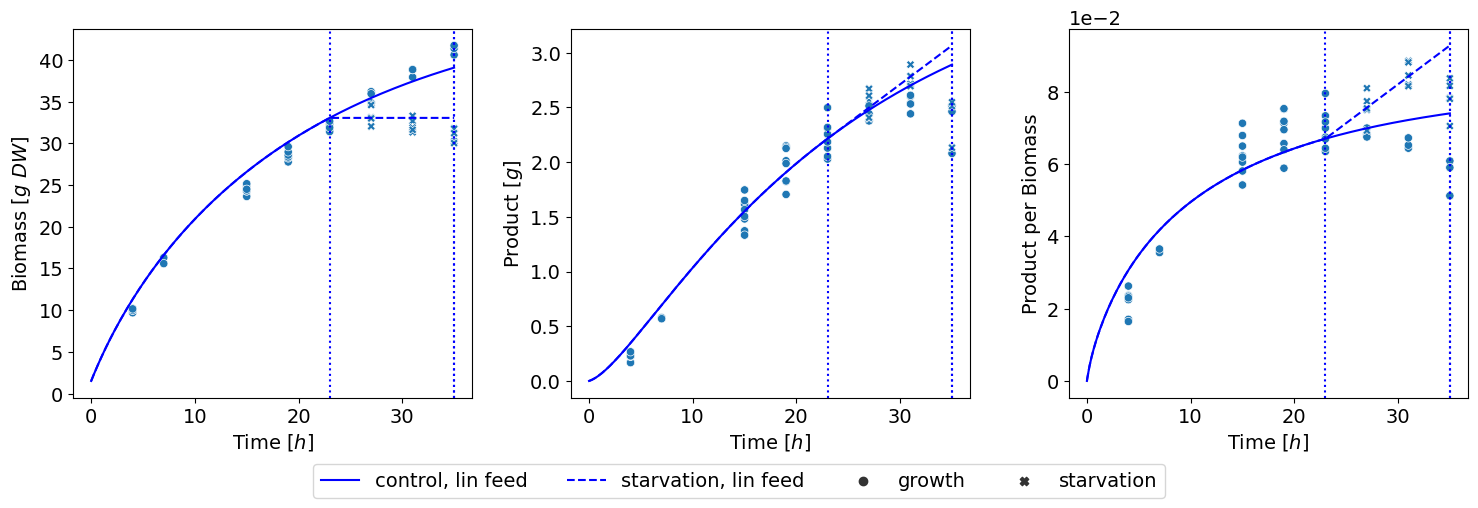

In [6]:
plot_results.plot_with_data(
    model_lin,
    model_lin_starv,
    "control, lin feed",
    "starvation, lin feed",
    colors=["b", "b",],
    style=["-", "--",],
    filename=f"{plot_path}/model_with_data.png",
    show_data="lin",
)


We can do this for the other ways to calculate $q_P$ as well.

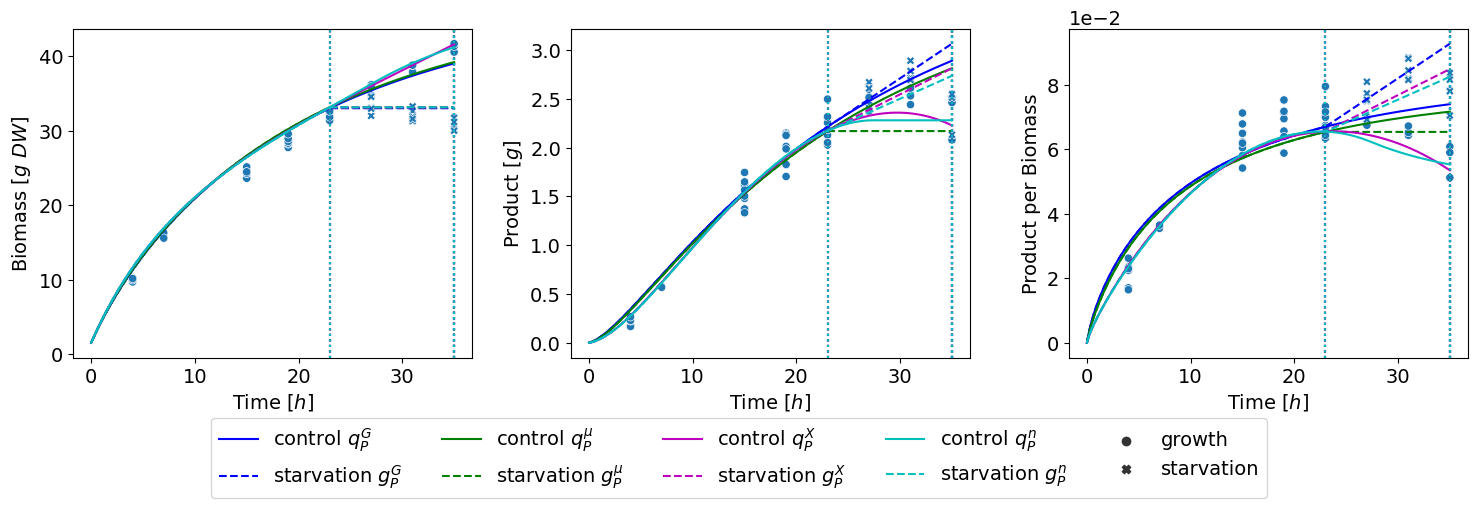

In [7]:
plot_results.plot_with_data(
    model_lin,
    model_lin_starv,
    model_lin_mu,
    model_lin_starv_mu,
    model_lin_X,
    model_lin_starv_X,
    model_lin_n,
    model_lin_starv_n,
    "control $q_P^G$",
    "starvation $g_P^G$",
    "control $q_P^{\mu}$",
    "starvation $g_P^{\mu}$",
    "control $q_P^X$",
    "starvation $g_P^X$",
    "control $q_P^n$",
    "starvation $g_P^n$",
    colors=["b", "b", 'g', 'g', 'm', 'm', 'c', 'c'],
    style=["-", "--", "-", "--", "-", "--", "-", "--",],
    filename=f"{plot_path}/model_with_data_qP.png",
    show_data="lin",
)

Next we compare the data with the values from the exponential feed.

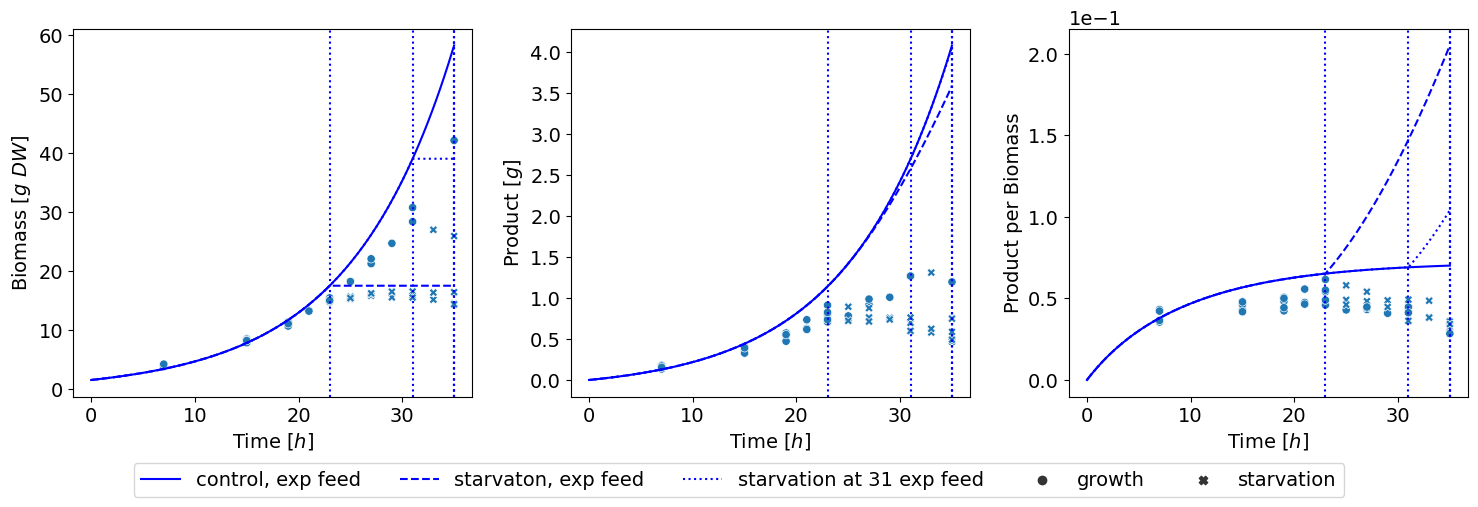

In [8]:
plot_results.plot_with_data(
    model_exp,
    model_exp_starv,
    model_exp_starv31,
    "control, exp feed",
    "starvaton, exp feed",
    "starvation at 31 exp feed",
    colors=["b", "b", "b"],
    style=["-", "--", ":"],
    filename=f"{plot_path}/model_with_data_exp.png",
    show_data="exp",
)


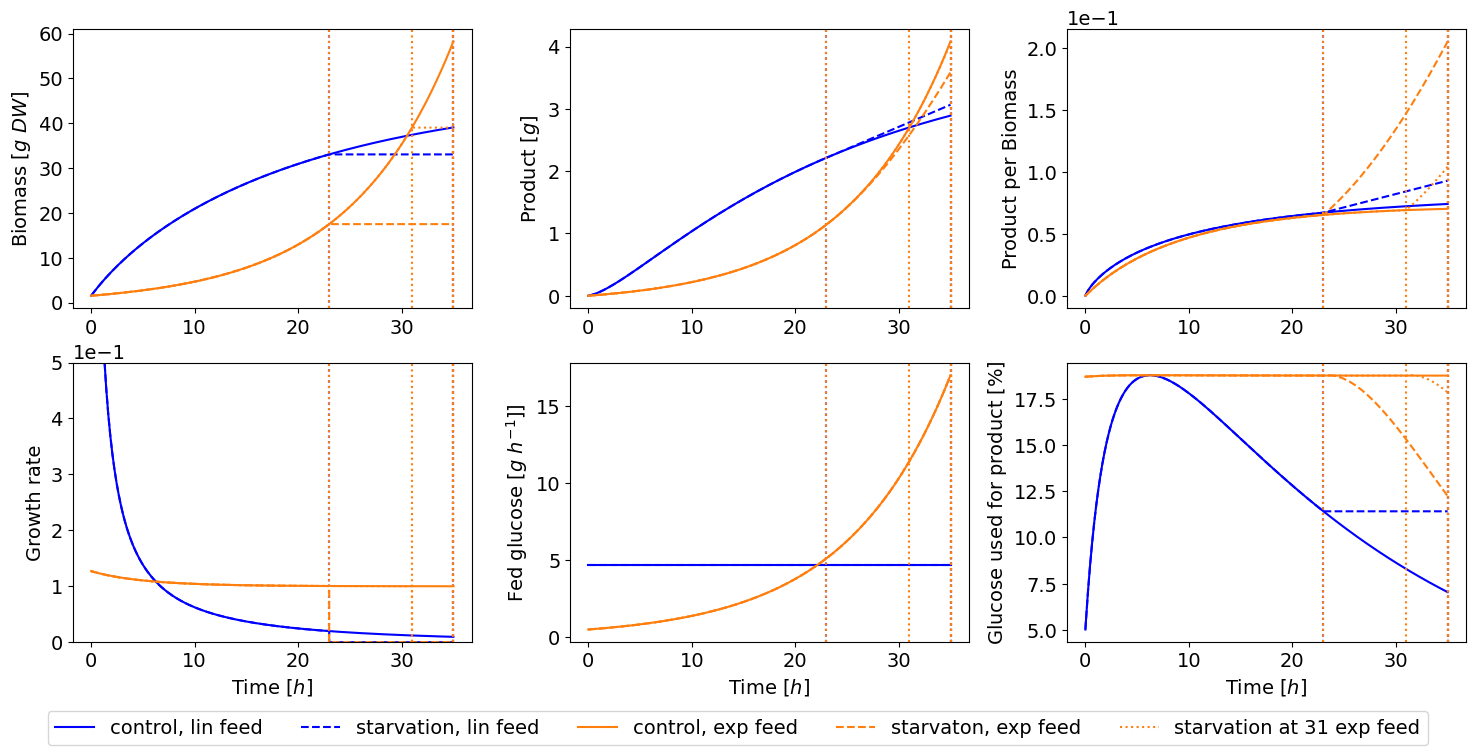

In [9]:
plot_results.plot_results(
    model_lin,
    model_lin_starv,
    model_exp,
    model_exp_starv,
    model_exp_starv31,
    "control, lin feed",
    "starvation, lin feed",
    "control, exp feed",
    "starvaton, exp feed",
    "starvation at 31 exp feed",
    colors=["b", "b", "tab:orange", "tab:orange", "tab:orange"],
    style=["-", "--", "-", "--", ":"],
    filename=f"{plot_path}/compare_exp_lin.png",
)


We plot the glucose usage.

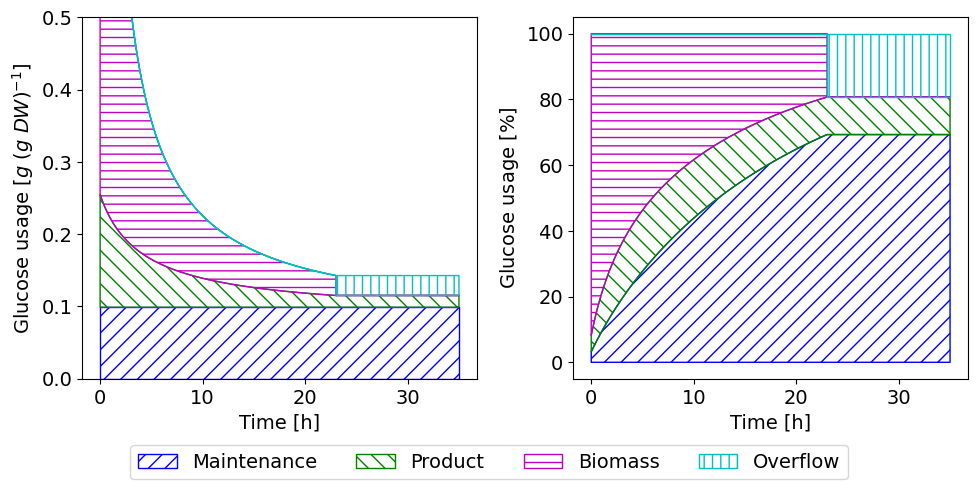

In [10]:
plot_results.energy_usage(
    model_lin_starv, filename=f"{plot_path}/lin_glucose_usage.png"
)


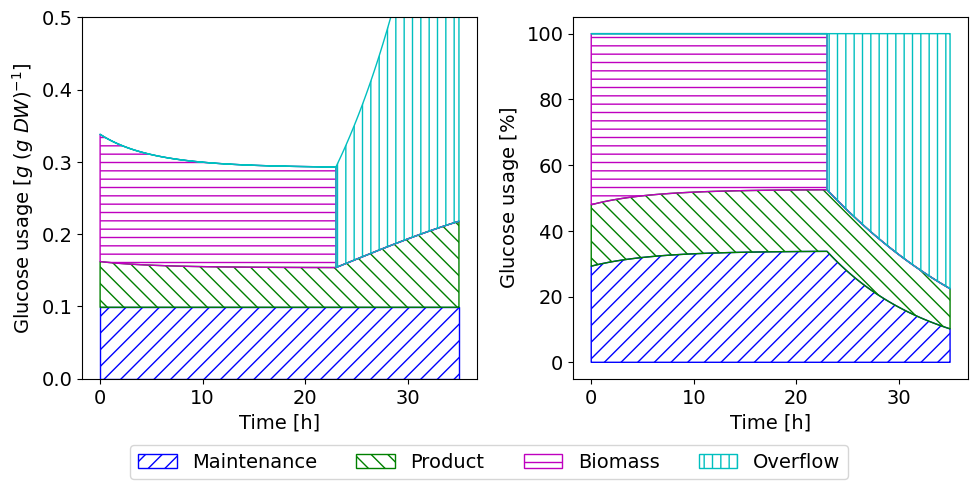

In [11]:
plot_results.energy_usage(
    model_exp_starv, filename=f"{plot_path}/exp_glucose_usage.png"
)


## Reference model

We use reference conditions to compare models with and without starvation.

In [12]:
# reference models
starvation_profile27 = [("growth", 27), ("starvation", 35)]
starvation_profile15_27 = [
    ("growth", 15),
    ("starvation", 20),
    ("growth", 27),
    ("starvation", 35),
]
model_starv27 = model.Model(phase_profile=starvation_profile27, **parameter_qG)
model_starv15_27 = model.Model(phase_profile=starvation_profile15_27, **parameter_qG)
model_starv27.calc()
model_starv15_27.calc()


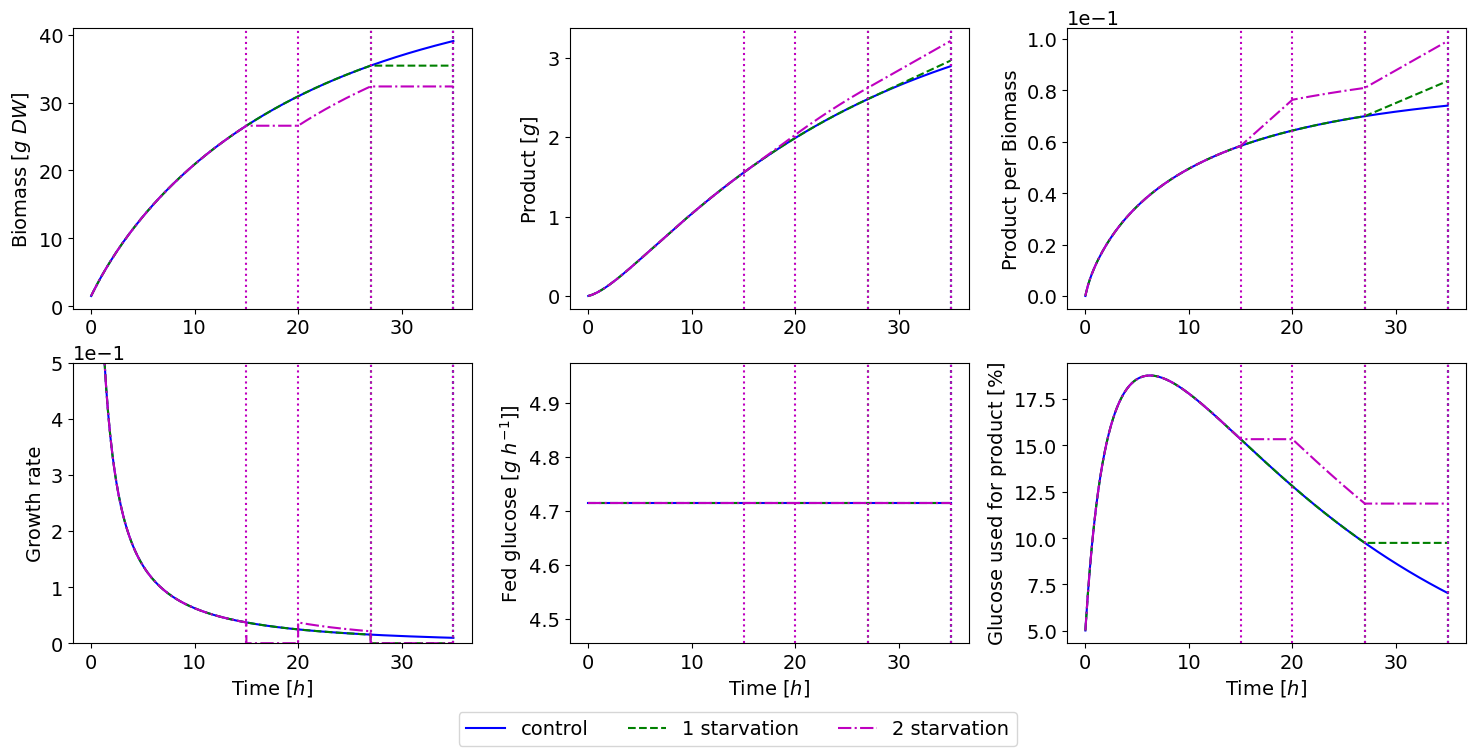

In [13]:
plot_results.plot_results(
    model_lin,
    model_starv27,
    model_starv15_27,
    "control",
    "1 starvation",
    "2 starvation",
)


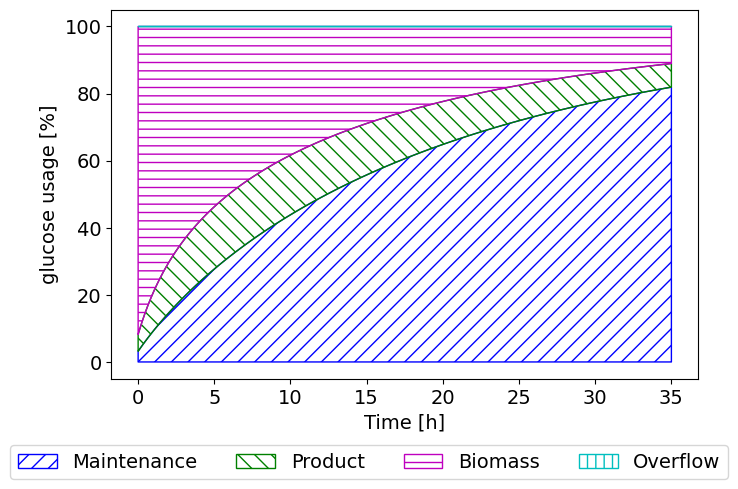

In [14]:
plot_results.energy_usage(
    model_lin,
    filename=f"{plot_path}/energie_usage_control.png",
    percent_only=True,
)

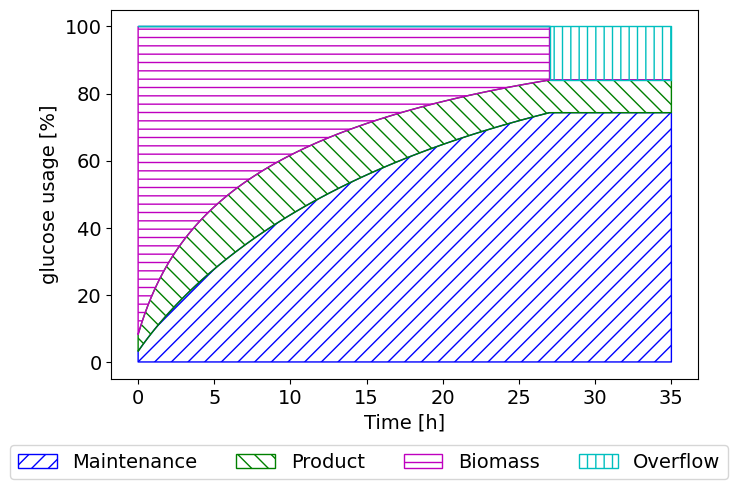

In [15]:
plot_results.energy_usage(
    model_starv27,
    filename=f"{plot_path}/energie_usage_27h_starv.png",
    percent_only=True,
)


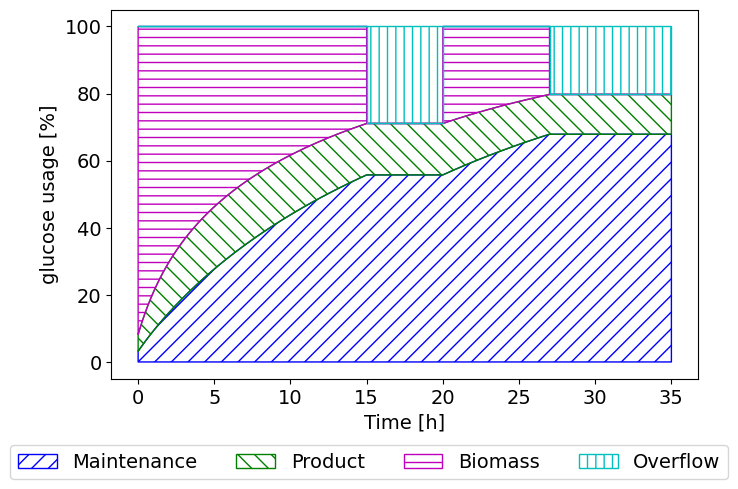

In [16]:
plot_results.energy_usage(
    model_starv15_27,
    filename=f"{plot_path}/energie_usage_15_27h_starv.png",
    percent_only=True,
)


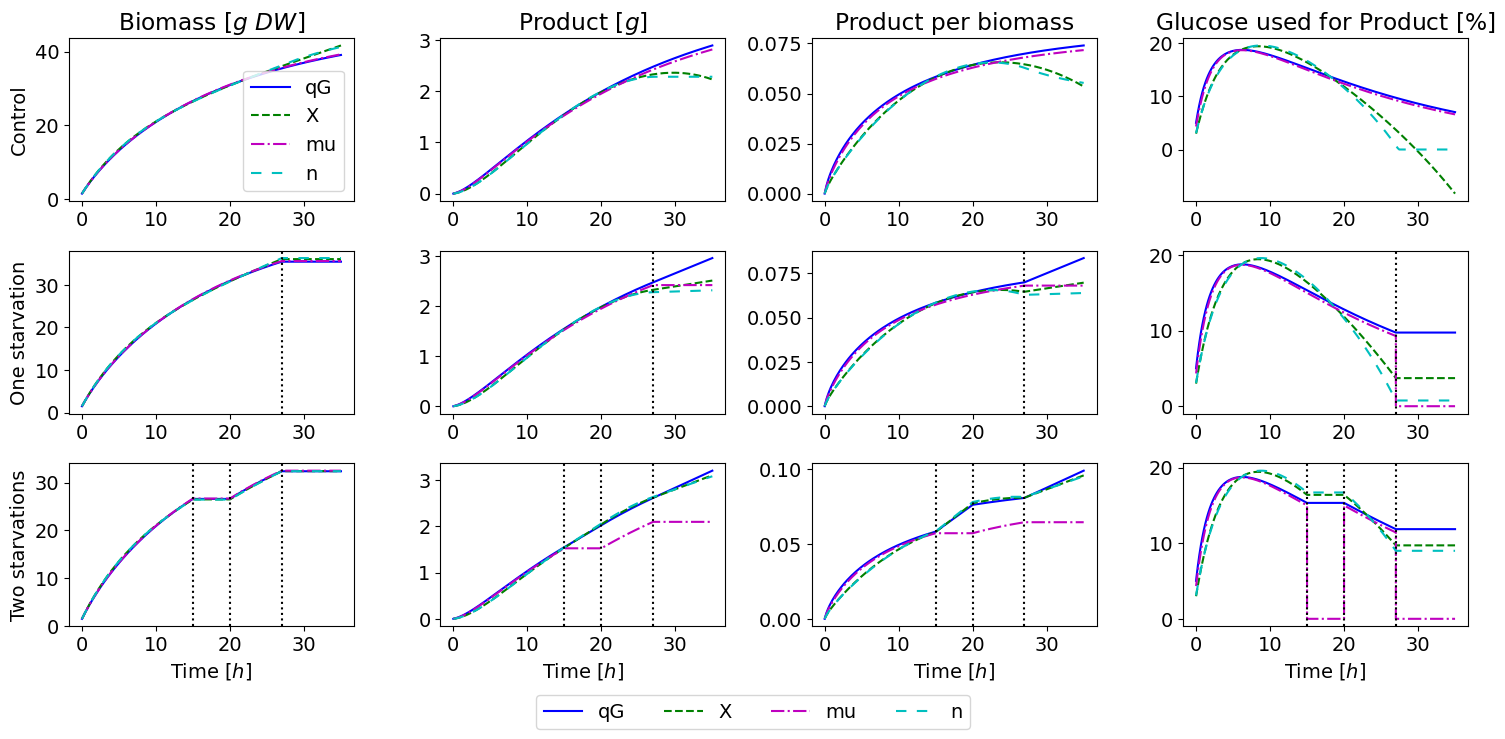

In [17]:
starvation_profiles = ([("growth", 35)], starvation_profile27, starvation_profile15_27)
qP_parameters = (parameter_qG, parameter_X, parameter_mu, parameter_n)
qP_labels = ("qG", "X", "mu", "n")
colors=["b", "g", "m", "c",]
styles=["-", "--", '-.', (0, (5, 5)),]

fig, axs = plt.subplots(3, 4, figsize=(15, 7.5))
for i, starvation_profile in enumerate(starvation_profiles):
    for parameter, label, c, ls in zip(qP_parameters, qP_labels, colors, styles):
        mod = model.Model(**parameter, phase_profile=starvation_profile)
        mod.calc()
        df = plot_results.calc_all(mod)
        axs[i, 0].plot(df.X, label=label if i == 0 else '', c=c, ls=ls)
        axs[i, 1].plot(df.P, c=c, ls=ls)
        axs[i, 2].plot(df.P_per_X, c=c, ls=ls)
        axs[i, 3].plot(df.qP_percent, c=c, ls=ls)

[axs[1, i].axvline(x=27, ls="dotted", c="k") for i in range(4)]
[axs[2, i].axvline(x=15, ls="dotted", c="k") for i in range(4)]
[axs[2, i].axvline(x=20, ls="dotted", c="k") for i in range(4)]
[axs[2, i].axvline(x=27, ls="dotted", c="k") for i in range(4)]

axs[0, 0].legend()
axs[0, 0].set_title("Biomass $[g \\ DW]$")
axs[0, 1].set_title("Product $[g]$")
axs[0, 2].set_title("Product per biomass")
axs[0, 3].set_title("Glucose used for Product $[\%]$")
axs[0, 0].set_ylabel("Control")
axs[1, 0].set_ylabel("One starvation")
axs[2, 0].set_ylabel("Two starvations")

[axs[2, i].set_xlabel("Time $[h]$") for i in range(4)]

fig.tight_layout()

fig.subplots_adjust(bottom=0.15)
fig.legend(loc="lower center", ncol=4)

plt.savefig(f"{plot_path}/compare_qP_ref_processes.png", bbox_inches="tight")
plt.show()


## Optimization

We step be step increase the degrees of freedom for optimization. We start with just changing starvation length and add feed changes in the next steps

### Optimize switch profile

In [18]:
# 1. optimize switch profile
def opt1_t(x):
    t_s1 = x[0]
    t_f2 = x[1]
    t_s2 = x[2]
    t_f1 = t_end - t_s1 - t_f2 - t_s2
    phase_profile = [
        ("growth", t_f1),
        ("starvation", t_f1 + t_s1),
        ("growth", t_f1 + t_s1 + t_f2),
        ("starvation", t_end),
    ]
    mod = model.Model(qf=model.lin_feed, **parameter_qG, phase_profile=phase_profile)
    return mod


def f(x):
    model = opt1_t(x)
    X, P = model.calc_X_P_end()
    return -P


opt1 = scipy.optimize.minimize(
    fun=f, x0=(4, 10, 4), bounds=[(0, max_starv), (min_feed, t_end), (0, max_starv2)]
)
opt1


      fun: -3.31637609051561
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-6.58059389e-02, -4.88498090e-06, -2.27905252e-02])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 76
      nit: 8
     njev: 19
   status: 0
  success: True
        x: array([ 5.        , 15.73411148,  8.        ])

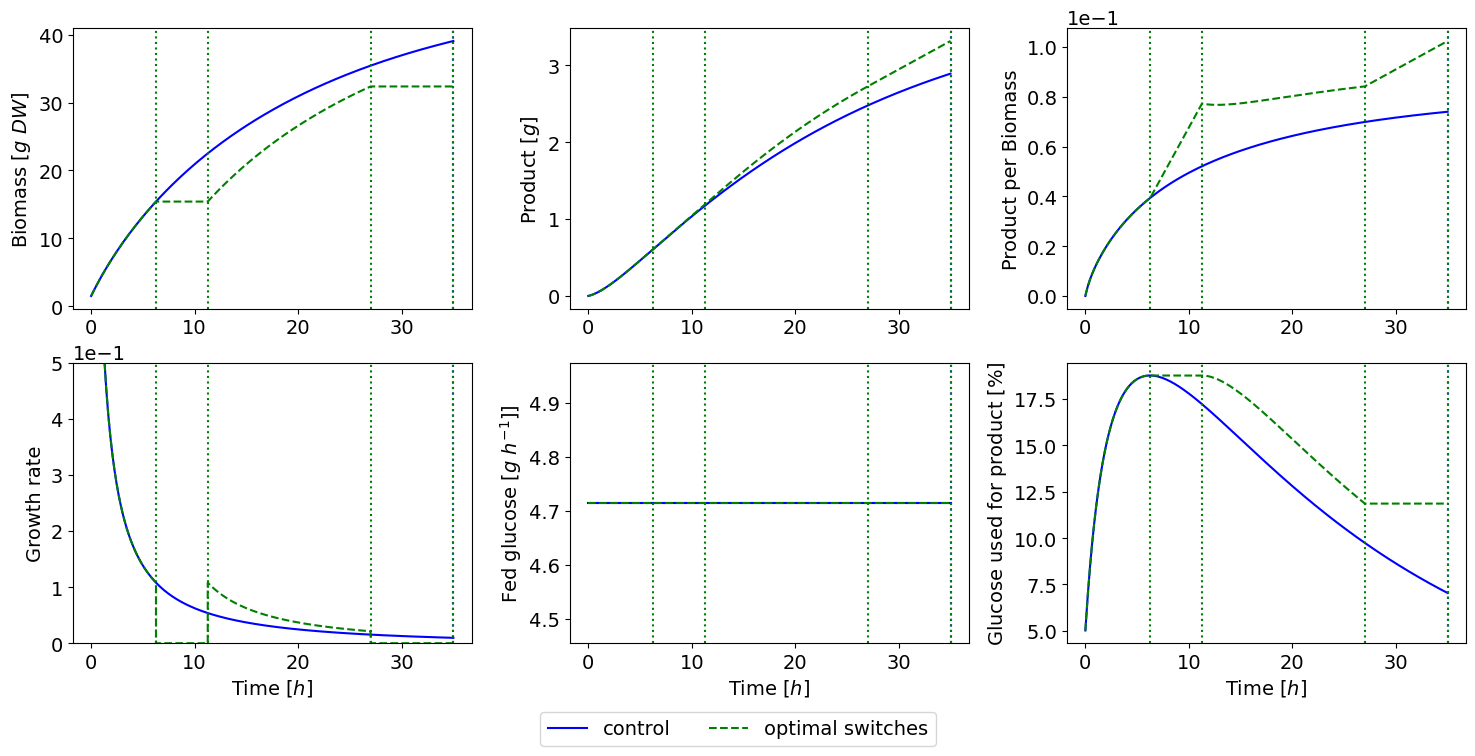

In [19]:
model1 = opt1_t(opt1.x)
model1.calc()
plot_results.plot_results(model_lin, model1, "control", "optimal switches")


### Adapt feed rate after first starvation.

We allow the feed rate to increase, this shortens the process.

In [20]:
# 2. adapt feed rate after 1. starvation
def opt2_t(x):
    t_s1 = x[0]
    t_f2 = x[1]
    t_s2 = x[2]
    feed2 = x[3]

    t_f1 = (0.5 - feed2 * (t_f2 + t_s2)) * 2 * t_end - t_s1
    t_newend = t_f1 + t_s1 + t_f2 + t_s2

    def feed(model, t):
        return 1 / t_end / 2 * (t <= (t_f1 + t_s1)) + feed2 * (t > (t_f1 + t_s1))

    phase_profile = [
        ("growth", t_f1),
        ("starvation", t_f1 + t_s1),
        ("growth", t_f1 + t_s1 + t_f2),
        ("starvation", t_newend),
    ]
    mod = model.Model(qf=feed, **parameter_qG, phase_profile=phase_profile)
    return mod


def f(x):
    mod = opt2_t(x)
    X, P = mod.calc_X_P_end()
    return -P


opt2 = scipy.optimize.minimize(
    fun=f,
    x0=(4, 4, 4, 1 / 70),
    bounds=[(0, max_starv), (min_feed, 35), (0, max_starv2), (1 / 100, 1 / 35)],
)
opt2

# opt2 = scipy.optimize.basinhopping(func=f, x0=(4, 4, 4, 1/70), minimizer_kwargs={'bounds': [(0, max_starv), (min_feed, 35), (0, max_starv), (1/100, 1/35)]})
# opt2


      fun: -3.9308667068350243
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.30269138e-03,  6.76063654e-03, -5.15916202e-03, -7.10542736e-07])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 155
      nit: 20
     njev: 31
   status: 0
  success: True
        x: array([5.        , 4.        , 8.        , 0.02695746])

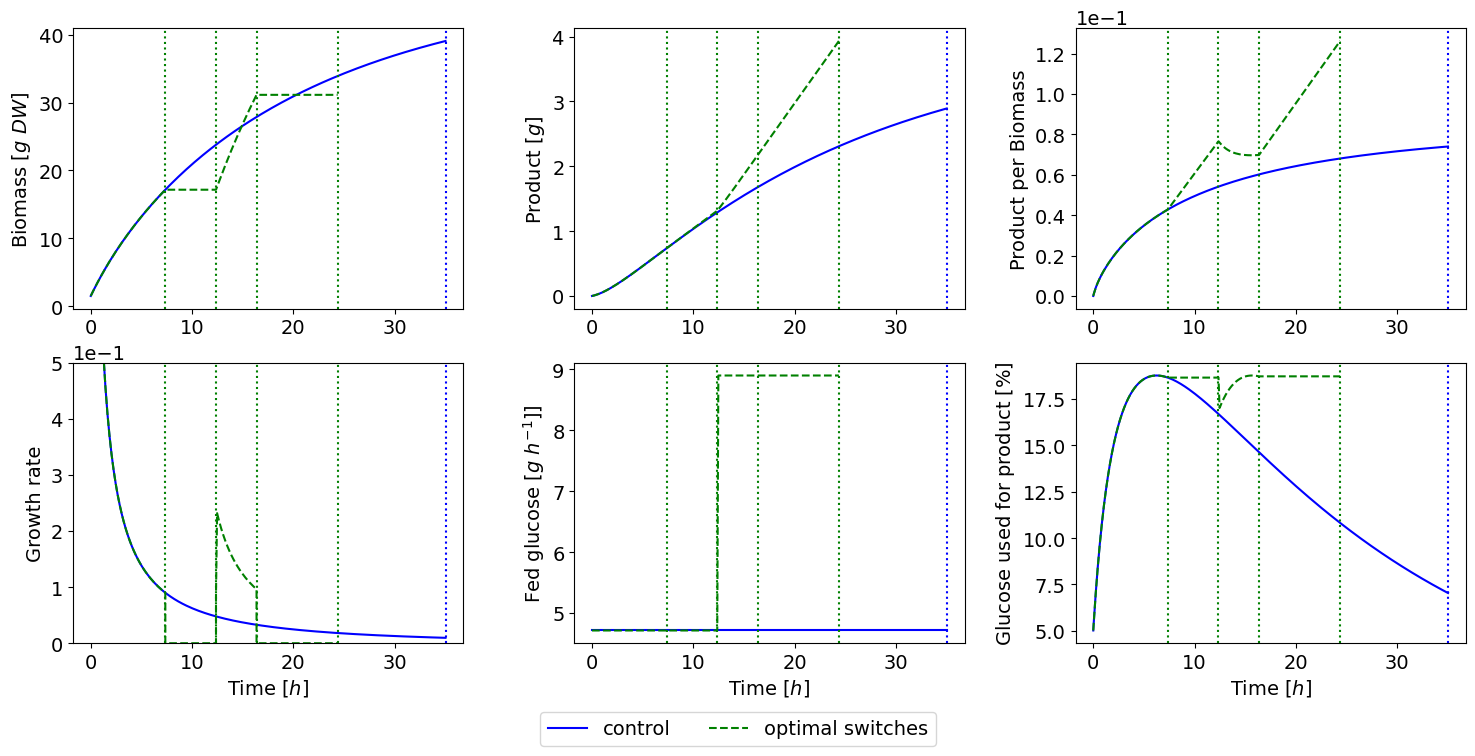

In [21]:
model2 = opt2_t(opt2.x)
model2.calc()
plot_results.plot_results(model_lin, model2, "control", "optimal switches")


### Optimize feed concentration.

Instead of the feed rate, we can change the feed concentration as well.

In [22]:
# 3. optimize t and feed concentration
def opt3_t(x, parmeter=parameter_qG):
    t_s1 = x[0]
    t_f2 = x[1]
    t_s2 = x[2]
    c_f1 = x[3]
    c_f2 = x[4]
    t_f1 = t_end - t_s1 - t_f2 - t_s2

    def Gf(t):
        return c_f1 * (t <= (t_f1 + t_s1)) + c_f2 * (t > (t_f1 + t_s1))

    phase_profile = [
        ("growth", t_f1),
        ("starvation", t_f1 + t_s1),
        ("growth", t_f1 + t_s1 + t_f2),
        ("starvation", t_end),
    ]
    mod = model.Model(
        qf=model.lin_feed, **parameter_qG, phase_profile=phase_profile, Gf=Gf
    )
    return mod


def f(x, parameter=parameter_qG):
    mod = opt3_t(
        x,
    )
    X, P = mod.calc_X_P_end()
    return -P


def cons_cX(x, parameter=parameter_qG):
    mod = opt3_t(x)
    mod.calc(plot_output=False)
    return max_cX - (mod.results.X / mod.results.V).max()


cons = {"type": "ineq", "fun": cons_cX}

opt3 = scipy.optimize.minimize(
    fun=f,
    x0=(4, 4, 4, 330, 330),
    bounds=[
        (0, max_starv),
        (min_feed, 10),
        (0, max_starv2),
        (300, 600),
        (300, 600),
    ],
    constraints=cons,
)
opt3


     fun: -4.127527558445679
     jac: array([-0.02989078, -0.0857172 , -0.12275481, -0.00498062, -0.00500947])
 message: 'Optimization terminated successfully'
    nfev: 181
     nit: 31
    njev: 30
  status: 0
 success: True
       x: array([  5.        ,   4.00000004,   8.        , 300.00000073,
       523.81499293])

In [23]:
# it is not clear the local optimum is a global optimum as well,
# basinhopping can be tried to check this, but is not necessary here.

# opt3 = scipy.optimize.basinhopping(
#     func=f,
#     x0=(4, 4, 4, 330, 330),
#     minimizer_kwargs={
#         "bounds": [
#             (0, max_starv),
#             (min_feed, 35),
#             (0, max_starv2),
#             (100, 660),
#             (100, 660),
#         ],
#         "constraints": cons,
#     },
# )
# opt3


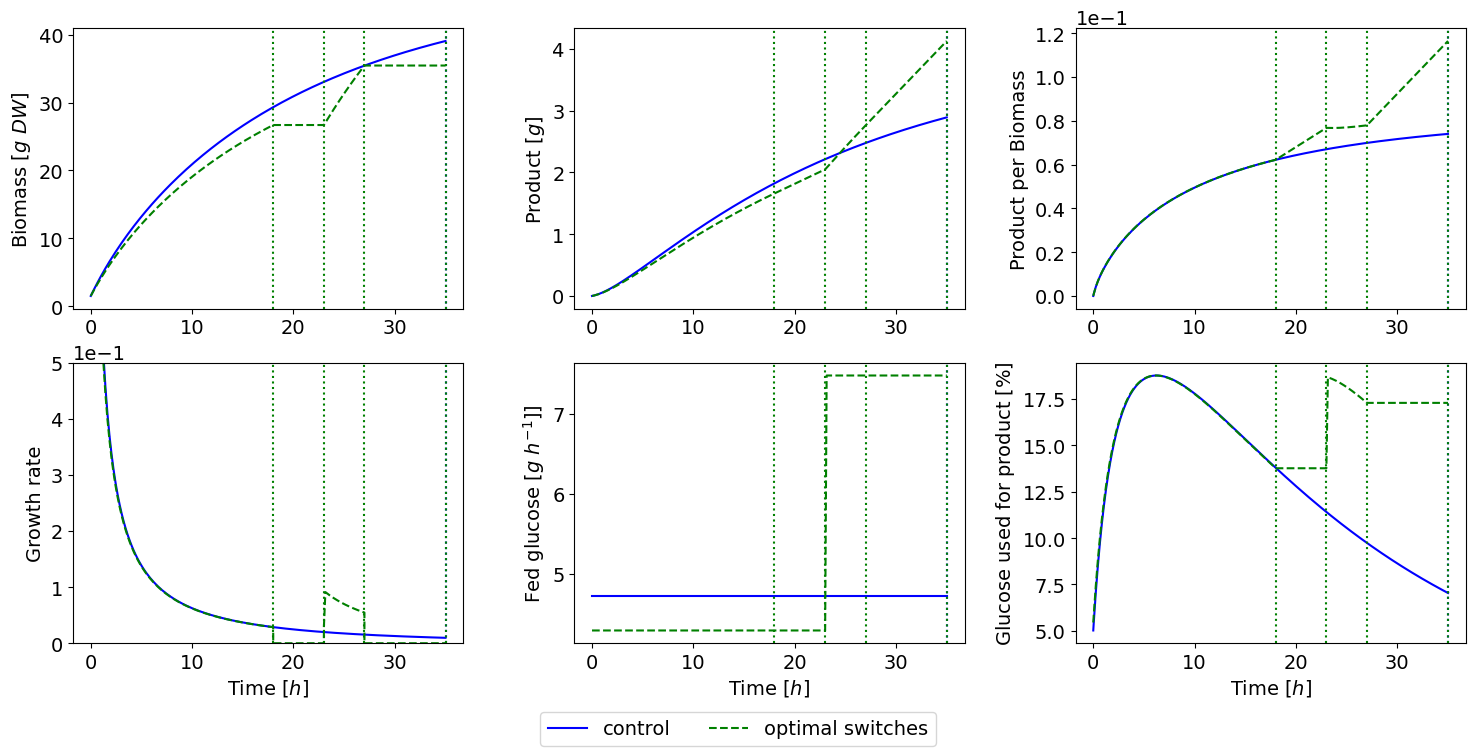

In [24]:
model3 = opt3_t(opt3.x)
model3.calc()
plot_results.plot_results(model_lin, model3, "control", "optimal switches")


### Summary of optimizations

We summarize all 3 optimizations in one plot.

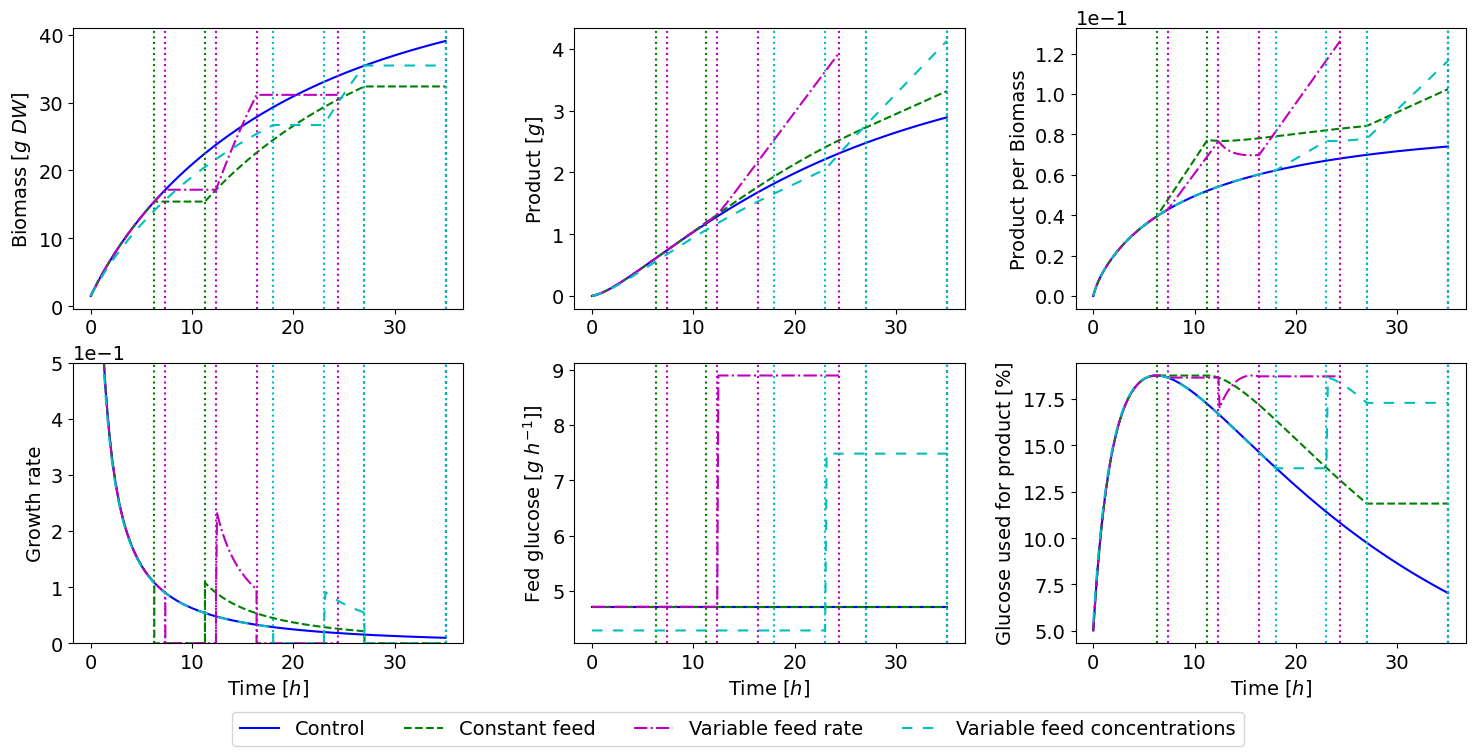

In [25]:
plot_results.plot_results(
    model_lin,
    model1,
    model2,
    model3,
    "Control",
    "Constant feed",
    "Variable feed rate",
    "Variable feed concentrations",
    filename=f"{plot_path}/compare_opt_4_phases.png",
)


In [1]:
X_ctrl, P_ctrl = model_lin.calc_X_P_end()
X1, P1 = model1.calc_X_P_end()
X2, P2 = model1.calc_X_P_end()
X2, P3 = model1.calc_X_P_end()

NameError: name 'model_lin' is not defined

## Different calculations of production rate

We now compare the different assumptions for $q_P$ with fixed feed in the beginning and flexible feed concentration in the end.

In [26]:
# 4 c_2 and t_f2 flexible
t_end = 35
param = parameter_qG.copy()


def opt4_t(x, parameter):
    t_s1 = max_starv
    t_f2 = x[0]
    t_s2 = max_starv2
    c_f1 = 330
    c_f2 = x[1]
    t_f1 = t_end - t_s1 - t_f2 - t_s2

    def Gf(t):
        return c_f1 * (t <= (t_f1 + t_s1)) + c_f2 * (t > (t_f1 + t_s1))

    phase_profile = [
        ("growth", t_f1),
        ("starvation", t_f1 + t_s1),
        ("growth", t_f1 + t_s1 + t_f2),
        ("starvation", t_end),
    ]
    mod = model.Model(
        qf=model.lin_feed, **parameter, phase_profile=phase_profile, Gf=Gf
    )
    return mod


def f4(x, parameter):
    mod = opt4_t(x, parameter)
    X, P = mod.calc_X_P_end()
    return -P


def cons_cX(x, parameter):
    mod = opt4_t(x, parameter)
    mod.calc(plot_output=False)
    return max_cX - (mod.results.X / mod.results.V).max()


cons_qG = {"type": "ineq", "fun": lambda x: cons_cX(x, parameter_qG)}
cons_X = {"type": "ineq", "fun": lambda x: cons_cX(x, parameter_X)}
cons_mu = {"type": "ineq", "fun": lambda x: cons_cX(x, parameter_mu)}
cons_n = {"type": "ineq", "fun": lambda x: cons_cX(x, parameter_n)}

opt4 = scipy.optimize.minimize(
    fun=f4,
    x0=(4, 330),
    bounds=[(min_feed, 20), (100, 660)],
    constraints=cons_qG,
    args=parameter_qG,
)
opt4


     fun: -3.8651886133492845
     jac: array([-0.05189005, -0.00556999])
 message: 'Optimization terminated successfully'
    nfev: 79
     nit: 25
    njev: 25
  status: 0
 success: True
       x: array([  4.        , 448.18573283])

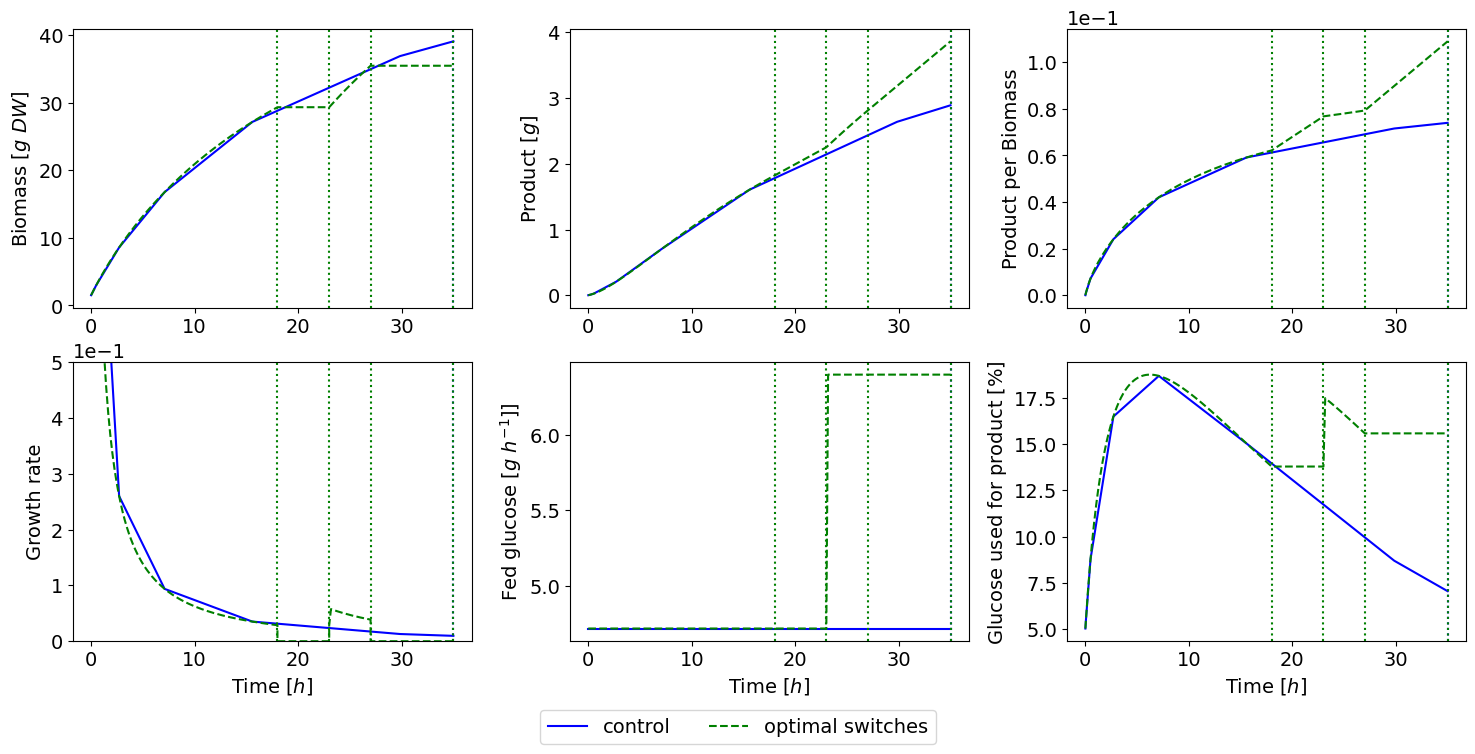

In [27]:
model4 = opt4_t(opt4.x, parameter_qG)
model4.calc(plot_output=True)
plot_results.plot_results(model_lin, model4, "control", "optimal switches")


In [28]:
# comparison of different options to calculate qP
min_feed = 5
print(opt4.x)

opt4_X = scipy.optimize.minimize(
    fun=f4,
    x0=(5, 1 / 70),
    bounds=[(min_feed, 25), (200, 600)],
    constraints=cons_X,
    args=parameter_X,
)
print(opt4_X.x)
model_X = opt4_t(opt4_X.x, parameter_X)

opt4_mu = scipy.optimize.minimize(
    fun=f4,
    x0=(8, 1 / 70),
    bounds=[(min_feed, 20), (300, 600)],
    constraints=cons_mu,
    args=parameter_mu,
)
print(opt4_mu.x)
model_mu = opt4_t(opt4_mu.x, parameter_mu)

opt4_n = scipy.optimize.minimize(
    fun=f4,
    x0=(6, 1 / 70),
    bounds=[(min_feed, 25), (200, 600)],
    constraints=cons_n,
    args=parameter_n,
)
print(opt4_n.x)

model_n = opt4_t(opt4_n.x, parameter_n)

model_X.calc()
model_mu.calc()
model_n.calc()


[  4.         448.18573283]
[ 13.76729357 200.        ]
[  6.47156781 404.90340206]
[ 13.21252387 200.        ]


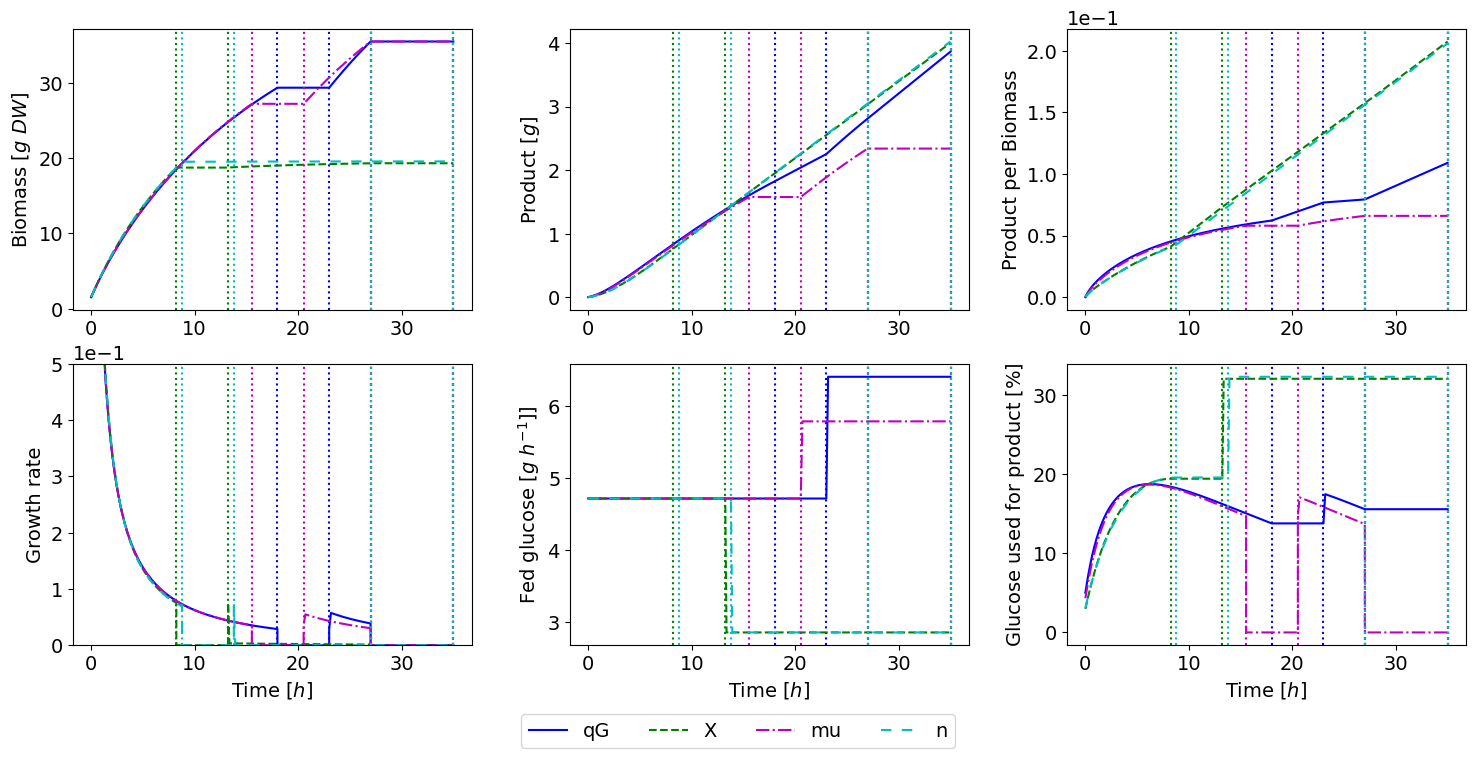

In [29]:
plot_results.plot_results(
    model4,
    model_X,
    model_mu,
    model_n,
    "qG",
    "X",
    "mu",
    "n",
    filename=f"{plot_path}/compare_qP_4_phases.png",
)


To get an overview where the optimum lies, we show the influence of the length of the growth phase between the starvation phases and the feed concentration. We just display combinations that to not exceed the biomass concentration limit. 

In [30]:
def results(t_f2, c_f2, parameter):
    mod = opt4_t((t_f2, c_f2), parameter)
    X, P = mod.calc_X_P_end()
    cX_max = (mod.results.X / mod.results.V).max()
    t_f2 = t_f2
    c_f2 = c_f2
    return (cX_max, t_f2, c_f2, P)

    

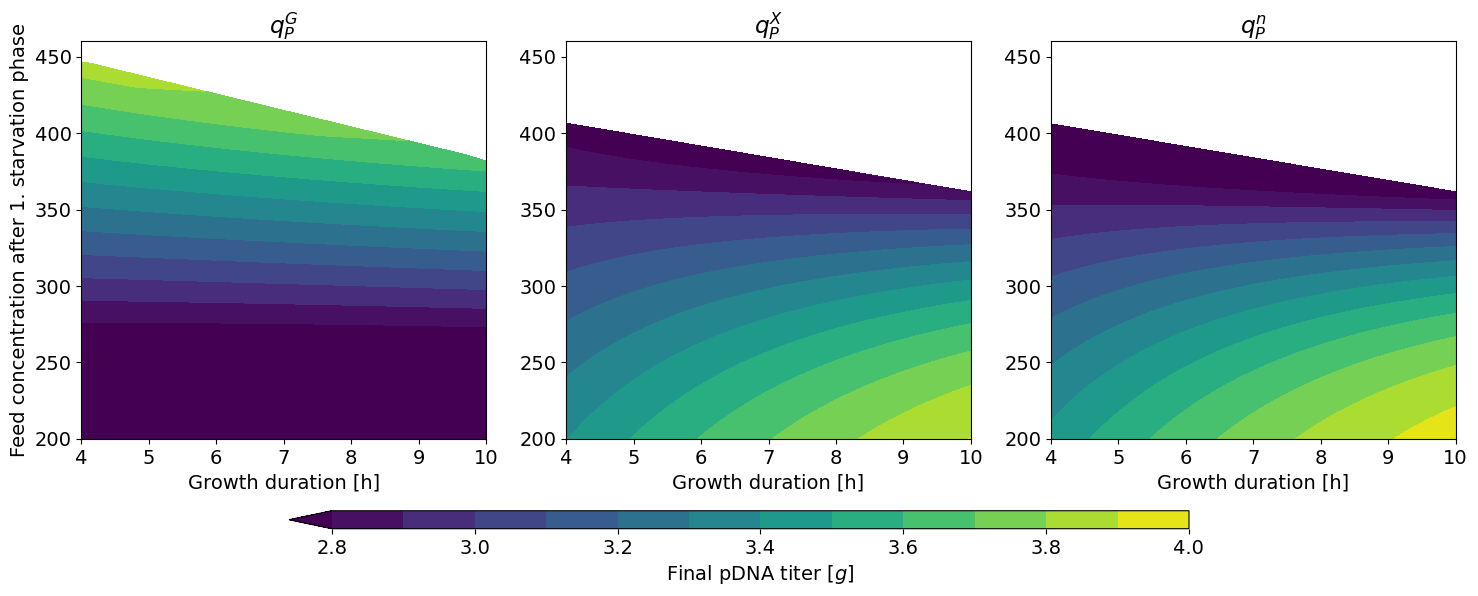

In [71]:
resolution = 100
min_cf = 200
t_f2 = np.linspace(4, 10, resolution)
c_f2 = np.linspace(min_cf, 600, resolution)
# data = [results(t, c, parameter) for t in t_f2 for c in c_f2]
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(15, 6))
for ax, parameter in zip((ax1, ax2, ax3), (parameter_qG, parameter_X, parameter_n)):
    data = list()
    with multiprocessing.Pool(min(multiprocessing.cpu_count()-1, 20)) as p:
        data += p.starmap(results, itertools.product(t_f2, c_f2, [parameter]))

    df = pd.DataFrame(data, columns=('cX_max', 't_f2', 'c_f2', 'P_end'))
    df_filtered = df[df.cX_max <= max_cX]

    x = df_filtered.t_f2
    y = df_filtered.c_f2
    z = df_filtered.P_end
    col = ax.tricontourf(x, y, z, levels=np.arange(2.8, 4, 0.1), extend="min")

    ax.set_xlabel("Growth duration [h]")
    ax.set_ylim(min_cf, 460)
ax1.set_ylabel("Feed concentration after 1. starvation phase")
ax1.set_title("$q_P^G$")
ax2.set_title("$q_P^X$")
ax3.set_title("$q_P^n$")
fig.tight_layout()
fig.subplots_adjust(bottom=0.25)
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.03])
cbar = fig.colorbar(col, orientation='horizontal', cax=cbar_ax)
cbar.ax.set_xlabel('Final pDNA titer $[g]$')

plt.savefig(f"{plot_path}/c_feed_phase_length.png", facecolor="white")
plt.show()

## Processes with 1 starvation phase

We now optimize for 1 starvation phase. We keep the feed rate and the length of the starvation phase variable.

In [35]:
# two stage process feed flexible
def opt_2phases(x):
    t_s = x[0]
    c_f = x[1]
    feed1 = x[2]

    t_end = 0.5 / feed1

    t_f = t_end - t_s

    def Gf(t):
        return c_f

    def feed(self, t):
        return feed1

    phase_profile = [("growth", t_f), ("starvation", t_end)]
    mod = model.Model(qf=feed, **parameter, phase_profile=phase_profile, Gf=Gf)
    return mod


def f(x):
    mod = opt_2phases(x)
    X, P = mod.calc_X_P_end()
    return -P


def cons_cX(x):
    mod = opt_2phases(x)
    mod.calc(plot_output=False)
    return max_cX - (mod.results.X / mod.results.V).max()


cons = {"type": "ineq", "fun": cons_cX}


parameter = parameter_qG.copy()
max_length = 35

opt_2ph = scipy.optimize.minimize(
    fun=f,
    x0=(5, 330, 1 / 70),
    bounds=[(0, max_starv2), (100, 660), (1 / max_length / 2, 1 / 35)],
    constraints=cons,
)
opt_2ph


     fun: -2.9631158938984536
     jac: array([-1.93438232e-02, -8.96078348e-03, -1.05955650e+02])
 message: 'Optimization terminated successfully'
    nfev: 36
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([7.99999986e+00, 3.30160029e+02, 1.42857143e-02])

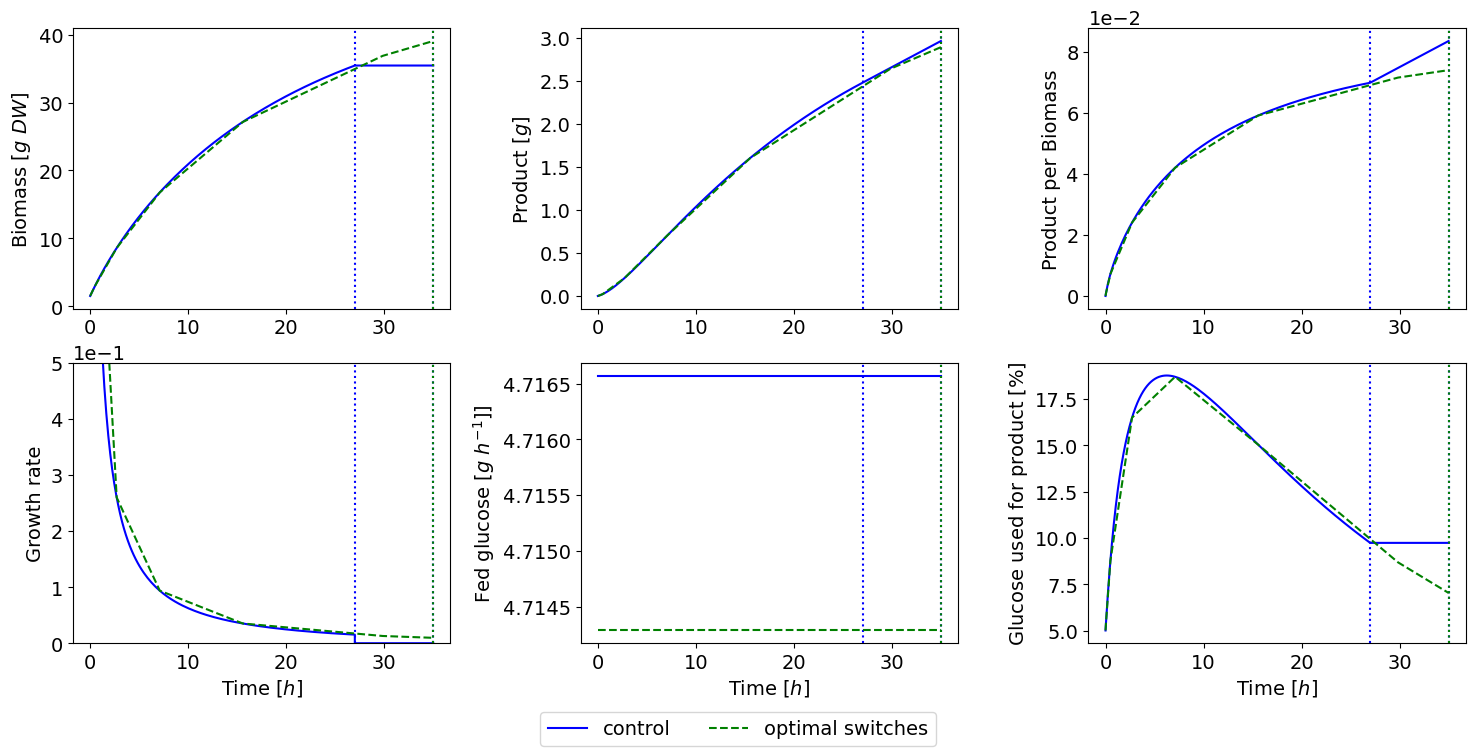

In [36]:
model_2phases = opt_2phases(opt_2ph.x)
model_2phases.calc(plot_output=True)

plot_results.plot_results(model_2phases, model_lin, "control", "optimal switches")


In [37]:
# comparison of different options to calculate qP

parameter = parameter_X.copy()

opt7_X = scipy.optimize.minimize(
    fun=f,
    x0=(5, 330, 1 / 70),
    bounds=[(0, max_starv2), (100, 660), (1 / max_length / 2, 1 / 35)],
    constraints=cons,
)

model_X = opt_2phases(opt7_X.x)

parameter = parameter_mu.copy()

opt7_mu = scipy.optimize.minimize(
    fun=f,
    x0=(5, 330, 1 / 70),
    bounds=[(0, max_starv2), (100, 660), (1 / max_length / 2, 1 / 35)],
    constraints=cons,
)

model_mu = opt_2phases(opt7_mu.x)
print(opt7_mu)

parameter = parameter_n.copy()

opt7_n = scipy.optimize.minimize(
    fun=f,
    x0=(5, 330, 1 / 70),
    bounds=[(0, max_starv2), (100, 660), (1 / max_length / 2, 1 / 35)],
    constraints=cons,
)

model_n = opt_2phases(opt7_n.x)

model_X.calc()
model_mu.calc()
model_n.calc()


     fun: -2.8434920983762773
     jac: array([ 4.15973365e-02, -8.50480795e-03, -9.66403951e+01])
 message: 'Optimization terminated successfully'
    nfev: 79
     nit: 18
    njev: 17
  status: 0
 success: True
       x: array([4.70955913e-12, 3.33511296e+02, 1.42857143e-02])


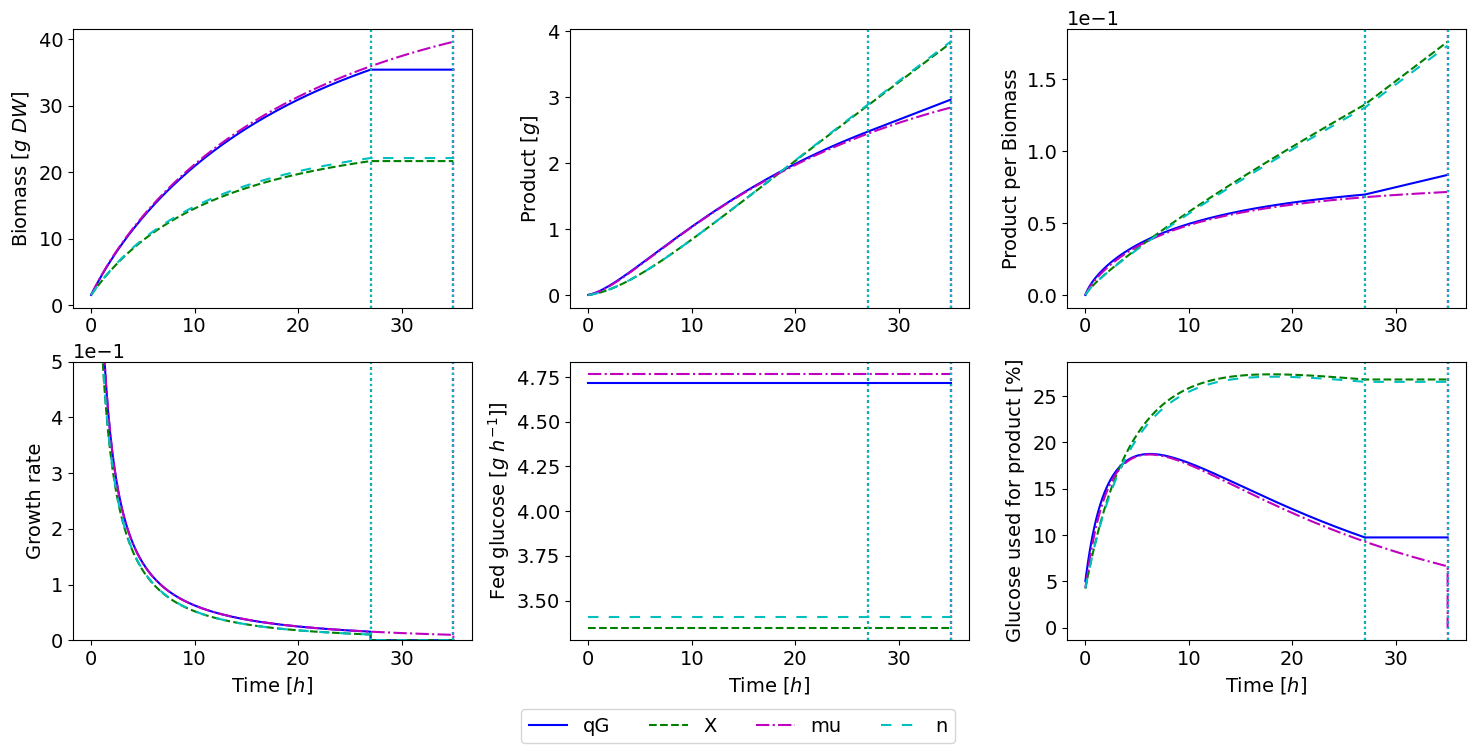

In [38]:
plot_results.plot_results(
    model_2phases,
    model_X,
    model_mu,
    model_n,
    "qG",
    "X",
    "mu",
    "n",
    filename=f"{plot_path}/compare_2stage.png",
)


In [39]:
X_ctrl, P_ctrl = model_lin.calc_X_P_end()
fed_G_ctrl = model_lin.Gf(0) * model_lin.qf(model_lin, 0) * 35
P_per_X_ctrl = P_ctrl / X_ctrl
t_ctrl = model_lin.phase_switches()[-1] + 9  # include batch phase
X_2phases, P_2phases = model_2phases.calc_X_P_end()
t_2_phases = model_2phases.phase_switches()[-1] + 9
X1, P1 = model1.calc_X_P_end()
t1 = model1.phase_switches()[-1] + 9
X2, P2 = model2.calc_X_P_end()
t2 = model2.phase_switches()[-1] + 9
X3, P3 = model3.calc_X_P_end()
t3 = model3.phase_switches()[-1] + 9
fed_G_3 = (
    model3.Gf(0) * model3.qf(model3, 0) * 23
    + model3.Gf(35) * model3.qf(model3, 35) * 12
)

print(f"1 strav {(P_2phases / P_ctrl - 1) * 100} %")
print(f"P/X {(P_2phases / X_2phases / P_per_X_ctrl -1) * 100}")
print(f"2 starv {(P1 / P_ctrl - 1) * 100} %")
print(f"P/X {(P1 / X1 / P_per_X_ctrl -1) * 100}")
print(f"var feed rate {(P2 / P_ctrl - 1) * 100} %")
print(f"rate {(P2 / t2 / (P_ctrl / t_ctrl) - 1) * 100} %")
print(f"P/X {(P2 / X2 / P_per_X_ctrl -1) * 100}")
print(f"var feed conc {(P3 / P_ctrl - 1) * 100} %")
print(f"yield {(P3 / fed_G_3 / (P_ctrl / fed_G_ctrl) - 1) * 100} %")
print(f"P/X {(P3 / X3 / P_per_X_ctrl -1) * 100}")


1 strav 2.4802858004830064 %
P/X 12.920612302429824
2 starv 14.697899693279904 %
P/X 38.42970834484485
var feed rate 35.95024898943828 %
rate 79.333793021292 %
P/X 70.56213690630719
var feed conc 42.751825775660656 %
yield 25.042553131546885 %
P/X 57.294871460441456


In [40]:
fed_G_3

188.36828474067337

In [41]:
fed_G_ctrl

165.0